<a href="https://colab.research.google.com/github/otwn/ComputerVision-ML-DL-Review/blob/master/sklearn/Module6_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-0.22.2.post1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 69.1MB/s 


In [ ]:
import sklearn
sklearn.__version__

'0.24.2'

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/scikit-learn-mooc/scikit-learn-mooc-master")
os.listdir()

['README.md',
 '.github',
 'python_scripts',
 'requirements.txt',
 '.binder',
 '.circleci',
 'notebooks',
 'plan.md',
 'jupyter-book',
 'figures',
 'local-install-instructions.md',
 'requirements-dev.txt',
 'slides',
 'build_tools',
 'LICENSE',
 '.gitignore',
 'index.md',
 'Makefile',
 'environment.yml',
 'environment-dev.yml',
 '.jupyter',
 'CONTRIBUTING.md',
 'datasets',
 'check_env.py']

# Introductory example to ensemble models

In [ ]:
from sklearn.datasets import fetch_california_housing
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(tree, data, target, n_jobs=-1)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

R2 score obtained by cross-validation: 0.354 +/- 0.087


We obtain fair results. However, as we previously presented in the "tree in depth" notebook, this model needs to be tuned to overcome over- or under-fitting. Indeed, the default parameters will not necessarily lead to an optimal decision tree. Instead of using the default value, we should search via cross-validation the optimal value of the important parameters such as max_depth, min_samples_split, or min_samples_leaf.

We recall that we need to tune these parameters, as decision trees tend to overfit the training data if we grow deep trees, but there are no rules on what each parameter should be set to. Thus, not making a search could lead us to have an underfitted or overfitted model.

Now, we make a grid-search to tune the hyperparameters that we mentioned earlier.

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    "max_depth": [5, 8, None],
    "min_samples_split": [2, 10, 30, 50],
    "min_samples_leaf": [0.01, 0.05, 0.1, 1]
}
cv = 3

tree = GridSearchCV(DecisionTreeRegressor(random_state=0),
                    param_grid=param_grid, cv=cv, n_jobs=-1)
cv_results = cross_validate(tree, data, target, n_jobs=-1, return_estimator=True)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

R2 score obtained by cross-validation: 0.523 +/- 0.107
CPU times: user 162 ms, sys: 22.9 ms, total: 185 ms
Wall time: 26 s


We see that optimizing the hyperparameters will have a positive effect on the statistical performance. However, it comes with a higher computational cost.

We can create a dataframe storing the important information collected during the tuning of the parameters and investigate the results.

Now we will use an ensemble method called bagging. 

In [ ]:
%%time
from sklearn.ensemble import BaggingRegressor

base_estimator = DecisionTreeRegressor(random_state=0)
bagging_regressor = BaggingRegressor(
    base_estimator=base_estimator, n_estimators=20, random_state=0
)
cv_results = cross_validate(bagging_regressor, data, target, n_jobs=-1)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

R2 score obtained by cross-validation: 0.642 +/- 0.083
CPU times: user 76.1 ms, sys: 11.2 ms, total: 87.3 ms
Wall time: 9.07 s


Without searching for optimal hyperparameters, the overall statistical performance of the bagging regressor is better than a single decision tree. In addition, the computational cost is reduced in comparison of seeking for the optimal hyperparameters.

# Ensemble method using bootstrapping

## Bagging

"Bagging" stands for Bootstrap AGGregatING. It uses bootstrap resampling (random sampling with replacement) to learn several models on random variations of the training set. At predict time, the predictions of each learner are aggregated to give the final predictions.


In [ ]:
import pandas as pd 
import numpy as np 

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)

def generate_data(n_samples=30):
  """Generate synthetic dataset. Returns `data_train`, `data_test`,`target_train`."""
  x_min, x_max = -3, 3
  x = rng.uniform(x_min, x_max, size=n_samples)
  noise = 4.0 * rng.randn(n_samples)
  y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
  y /= y.std()

  data_train = pd.DataFrame(x, columns=["Feature"])
  data_test = pd.DataFrame(
      np.linspace(x_max, x_min, num=300), columns=["Feature"]
  )
  target_train = pd.Series(y, name="Target")

  return data_train, data_test, target_train

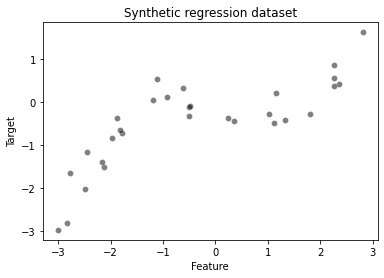

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
_ = plt.title("Synthetic regression dataset")

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

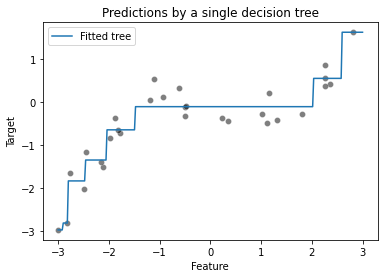

In [ ]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
plt.plot(data_test, y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

## Bootstrap resampling 

A bootstrap sample corresponds to a resampling with replacement, of the original dataset, a sample that is the same size as the original dataset. Thus, the bootstrap sample will contain some data points several times while some of the original data points will not be present.

In [ ]:
def bootstrap_sample(data, target):
  # Indices corresponding to a sampling with replacement of the same sample
  # size than the original data
  bootstrap_indices = rng.choice(
      np.arange(target.shape[0]), size=target.shape[0], replace=True,
  )
  # In pandas, we need to use `.iloc` to extract rows using an integer
  # position index
  data_bootstrap = data.iloc[bootstrap_indices]
  target_bootstrap = target.iloc[bootstrap_indices]
  return data_bootstrap, target_bootstrap

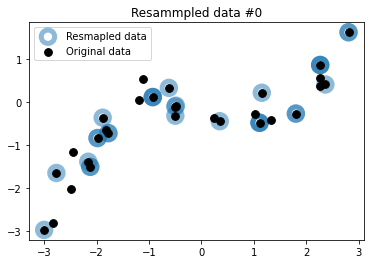

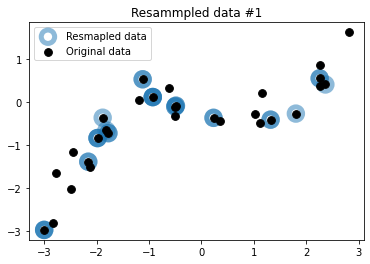

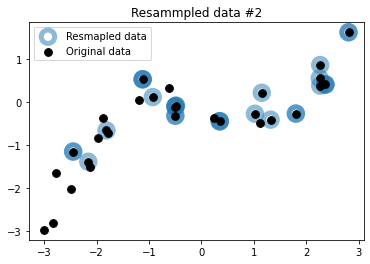

In [ ]:
n_bootstraps = 3

for bootstrap_idx in range(n_bootstraps):
  # draw a bootstrap from the original data
  data_bootstrap, target_bootstrap = bootstrap_sample(data_train, target_train)
  plt.figure()
  plt.scatter(data_bootstrap["Feature"], target_bootstrap, color="tab:blue", facecolors="none",
              alpha=0.5, label="Resmapled data", s=180, linewidth=5)
  plt.scatter(data_train["Feature"], target_train, color="black", s=60, alpha=1, label="Original data")
  plt.title(f"Resammpled data #{bootstrap_idx}")
  plt.legend()

Observe that the 3 variations all share common points with the original dataset. Some of the points are randomly resampled several times and appear as darker blue circles.

In [ ]:
data_train_huge, data_test_huge, target_train_huge = generate_data(n_samples=100_000)

data_bootstrap_sample, target_bootsrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge
)

ration_unique_sample = (np.unique(data_bootstrap_sample).size/data_bootstrap_sample.size)

print(
    f"Percentage of samples present in the original dataset: "
    f"{ration_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


On average, ~63.2% of the original data points of the original dataset will be present in a given bootstrap sample. The other ~36.8% are repeated samples.

In [ ]:
bag_of_trees = []

for bootstrap_idx in range(n_bootstraps):
  tree = DecisionTreeRegressor(max_depth=3, random_state=0)

  data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
      data_train, target_train
  )
  tree.fit(data_bootstrap_sample, target_bootstrap_sample)
  bag_of_trees.append(tree)

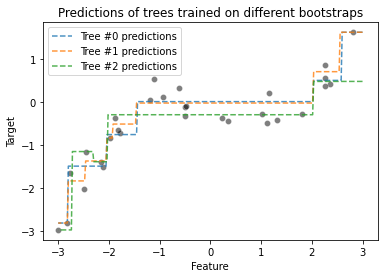

In [ ]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
  tree_predictions = tree.predict(data_test)
  plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8, label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

## Aggregating

Once our trees are fitted and we are able to get predictions for each of them. In regression, the most straightforward way to combine those predictions is just to average them: for a given test data point, we feed the input feature values to each of the n trained models in the ensemble and as a result compute n predicted values for the target variable. The final prediction of the ensemble for the test data point is the average of those n values.

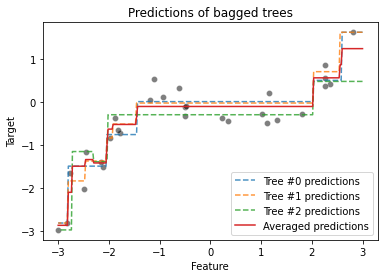

In [ ]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
  tree_predictions = tree.predict(data_test)
  plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8, label=f"Tree #{tree_idx} predictions")
  bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test, bag_predictions, label="Averaged predictions", linestyle="-")
plt.legend()
_ = plt.title("Predictions of bagged trees")

## Bagging in scikit-learn


In [ ]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)

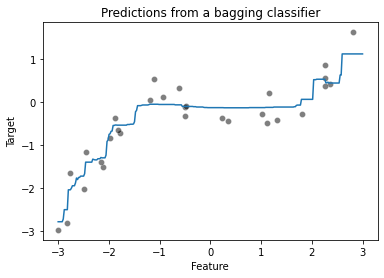

In [ ]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

Because we use 100 trees in the ensemble, the average prediction is indeed slightly smoother but very similar to our previous average plot.

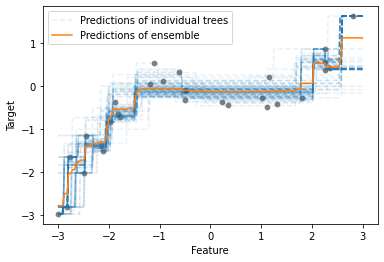

In [ ]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
  label = "Predictions of individual trees" if tree_idx == 0 else None
  tree_predictions = tree.predict(data_test)
  plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.1, color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions, color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()

## Bagging complex pipelines

While we used a decision tree as a base model, nothing prevents us of using any other type of model.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)


This pipeline first scales the data to the 0-1 range with `MinMaxScaler`.
Then it extracts degree-4 polynomial features. The resulting features will
all stay in the 0-1 range by construction: if `x` lies in the 0-1 range then
`x ** n` also lies in the 0-1 range for any value of `n`.

Then the pipeline feeds the resulting non-linear features to a regularized
linear regression model for the final prediction of the target variable.

Note that we intentionally use a small value for the regularization parameter
`alpha` as we expect the bagging ensemble to work well with slightly overfit
base models.

The ensemble itself is simply built by passing the resulting pipeline as the
`base_estimator` parameter of the `BaggingRegressor` class:

In [ ]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0
)
_ = bagging.fit(data_train, target_train)

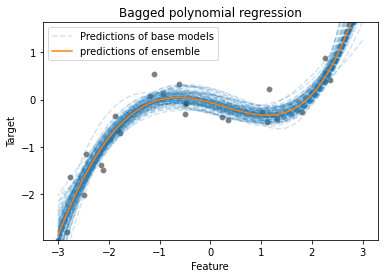

In [ ]:
for i, regressor in enumerate(bagging.estimators_):
  regressor_predictions = regressor.predict(data_test)
  base_model_line = plt.plot(
      data_test, regressor_predictions, linestyle="--", alpha=0.2,
      label="Predictions of base models" if i == 0 else None,
      color="tab:blue"
  )

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
bagging_predictions =bagging.predict(data_test)
plt.plot(data_test, bagging_predictions, color="tab:orange", label="predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")

The predictions of this bagged polynomial regression model looks qualitatively better than the bagged trees. This is somewhat expected since the base model better reflects our knowldege of the true data generating process.

# Exercise M6.01

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5
)

Create a BaggingRegressor and provide a DecisionTreeRegressor to its parameter base_estimator. Train the regressor and evaluate its statistical performance on the testing set using the mean absolute error.

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

tree = DecisionTreeRegressor()
bagging = BaggingRegressor(base_estimator=tree, n_jobs=2)

bagging.fit(data_train, target_train)
target_predicted = bagging.predict(data_test)
print(f"Basic mean absolute error of the bagging regressor:\n"
      f"{mean_absolute_error(target_test, target_predicted):.2f} k$")

Basic mean absolute error of the bagging regressor:
36.40 k$


Now, create a `RandomizedSearchCV` instance using the previous model and
tune the important parameters of the bagging regressor. Find the best
parameters  and check if you are able to find a set of parameters that
improve the default regressor still using the mean absolute error as a
metric.

In [ ]:
for param in bagging.get_params().keys():
  print(param)

base_estimator__ccp_alpha
base_estimator__criterion
base_estimator__max_depth
base_estimator__max_features
base_estimator__max_leaf_nodes
base_estimator__min_impurity_decrease
base_estimator__min_impurity_split
base_estimator__min_samples_leaf
base_estimator__min_samples_split
base_estimator__min_weight_fraction_leaf
base_estimator__random_state
base_estimator__splitter
base_estimator
bootstrap
bootstrap_features
max_features
max_samples
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [ ]:
from scipy.stats import randint 
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": randint(10, 30),
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0],
    "base_estimator__max_depth": randint(3, 10),
}

rscv = RandomizedSearchCV(
    bagging, param_grid, n_iter=20, scoring="neg_mean_absolute_error"
)
_ = rscv.fit(data_train, target_train)

In [ ]:
import pandas as pd 
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = pd.DataFrame(rscv.cv_results_)
cv_results = cv_results[columns].sort_values(by="rank_test_score")
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results

,param_n_estimators,param_max_samples,param_max_features,param_base_estimator__max_depth,mean_test_score,std_test_score,rank_test_score
17,14,0.8,0.8,8,41.669155,0.489694,1
6,28,0.8,0.5,9,43.379753,1.418984,2
15,21,1,1,6,45.362492,1.350430,3
16,14,0.5,0.5,9,45.822707,1.782462,4
10,12,0.8,0.8,6,45.939630,0.859338,5
19,29,0.5,0.8,5,47.923121,1.058303,6
4,29,0.8,1,5,48.065609,1.191075,7
0,14,1,1,5,48.558176,0.969378,8
13,11,1,0.5,7,49.390223,1.524092,9
5,21,0.8,0.5,6,49.664670,1.163917,10


In [ ]:
target_predicted = rscv.predict(data_test)
print(f"Mean absolute error after tuning of the bagging regressor:\n"
      f"{mean_absolute_error(target_test, target_predicted):.2f} k$")

Mean absolute error after tuning of the bagging regressor:
42.12 k$


# Random forests

Random forests are a popular model in machine learning. They are a
modification of the bagging algorithm. In bagging, any classifier or
regressor can be used. In random forests, the base classifier or regressor
is always a decision tree.

Random forests have another particularity: when training a tree, the search
for the best split is done only on a subset of the original features taken at
random. The random subsets are different for each split node. The goal is to
inject additional randomization into the learning procedure to try to
decorrelate the prediction errors of the individual trees.

Therefore, random forests are using **randomization on both axes of the data
matrix**:

- by **bootstrapping samples** for **each tree** in the forest;
- randomly selecting a **subset of features** at **each node** of the tree.

In [ ]:
import pandas as pd 

adult_census = pd.read_csv("./datasets/adult-census.csv")
target_name = "class"
data = adult_census.drop(columns=[target_name, "education-num"])
target = adult_census[target_name]

The adult census contains some categorical data and we encode the categorical features using an OrdinalEncoder since tree-based models can work very efficiently with such a naive representation of categorical variables.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.compose import make_column_transformer, make_column_selector 

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=0)
)

In [ ]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, data, target)

print(f"Decision tree classifier: "
      f"{scores_tree.mean():.3f} +/- {scores_tree.std():.3f}")

Decision tree classifier: 0.820 +/- 0.006


In [ ]:
from sklearn.ensemble import BaggingClassifier

bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50, n_jobs=2, random_state=0
    )
)

In [ ]:
scores_bagged = cross_val_score(bagged_trees, data, target)
print(f"Decision tree classifier: "
      f"{scores_bagged.mean():.3f} +/- {scores_bagged.std():.3f}")

Decision tree classifier: 0.846 +/- 0.005


In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)
)

In [ ]:
scores_rf = cross_val_score(random_forest, data, target)
print(f"Random forest classifier: "
      f"{scores_rf.mean():.3f} +/- {scores_rf.std():.3f}")

Random forest classifier: 0.851 +/- 0.004


## Details about default hyperparameters

For random forests, it is possible to control the amount of randomness for
each split by setting the value of `max_features` hyperparameter:

- `max_feature=0.5` means that 50% of the features are considered at each
  split;
- `max_features=1.0` means that all features are considered at each split
  which effectively disables feature subsampling.

By default, `RandomForestRegressor` disables feature subsampling while
`RandomForestClassifier` uses `max_features=np.sqrt(n_features)`. These
default values reflect good practices given in the scientific literature.

However, `max_features` is one of the hyperparameters to consider when tuning
a random forest:
- too much randomness in the trees can lead to underfitted base models and
  can be detrimental for the ensemble as a whole,
- too few randomness in the trees leads to more correlation of the prediction
  errors and as a result reduce the benefits of the averaging step in terms
  of overfitting control.

In scikit-learn, the bagging classes also expose a `max_features` parameter.
However, `BaggingClassifier` and `BaggingRegressor` are agnostic with respect
to their base model and therefore random feature subsampling can only happen
once before fitting each base model instead of several times per base model
as is the case when adding splits to a given tree.

We summarize these details in the following table:

| Ensemble model class     | Base model class          | Default value for `max_features`   | Features subsampling strategy |
|--------------------------|---------------------------|------------------------------------|-------------------------------|
| `BaggingClassifier`      | User specified (flexible) | `n_features` (no&nbsp;subsampling) | Model level                   |
| `RandomForestClassifier` | `DecisionTreeClassifier`  | `sqrt(n_features)`                 | Tree node level               |
| `BaggingRegressor`       | User specified (flexible) | `n_features` (no&nbsp;subsampling) | Model level                   |
| `RandomForestRegressor`  | `DecisionTreeRegressor`   | `n_features` (no&nbsp;subsampling) | Tree node level               |

# Exercise M6.02

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split 

penguins = pd.read_csv("./datasets/penguins_regression.csv")
feature_names = ["Flipper Length (mm)"]
target_name = "Body Mass (g)"
data, target = penguins[feature_names], penguins[target_name]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

In [ ]:
from sklearn.metrics import mean_absolute_error 
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=3)
forest.fit(data_train, target_train)
target_predicted = forest.predict(data_test)
print(f"Mean absolute error: "
      f"{mean_absolute_error(target_test, target_predicted):.3f} grams")

Mean absolute error: 338.832 grams


The next steps of this exercise are to:

- create a new dataset containing the penguins with a flipper length
  between 170 mm and 230 mm;
- plot the training data using a scatter plot;
- plot the decision of each individual tree by predicting on the newly
  created dataset;
- plot the decision of the random forest using this newly created dataset.

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">The trees contained in the forest that you created can be accessed
with the attribute <tt class="docutils literal">estimators_</tt>.</p>
</div>

In [ ]:
import numpy as np 

data_ranges = pd.DataFrame(np.linspace(170, 235, num=300), columns=data.columns) 
tree_predictions = []
for tree in forest.estimators_:
  tree_predictions.append(tree.predict(data_ranges))

forest_predictions = forest.predict(data_ranges)

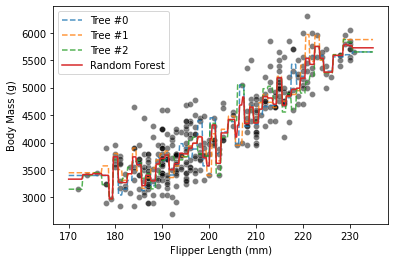

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.scatterplot(data=penguins, x=feature_names[0], y=target_name, color="black", alpha=0.5)
# plot tree predictions
for tree_idx, predictions in enumerate(tree_predictions):
  plt.plot(data_ranges, predictions, label=f"Tree #{tree_idx}", linestyle="--", alpha=0.8)

plt.plot(data_ranges, forest_predictions, label=f"Random Forest")
_ = plt.legend()

# Adaptive Boosting (AdaBoost)

In [ ]:
import pandas as pd

penguins = pd.read_csv("./datasets/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]
range_features = {
    feature_name: (data[feature_name].min()-1, data[feature_name].max()+1)
    for feature_name in data.columns
}

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

def plot_decision_function(fitted_classifier, range_features, ax=None):
  """Plot the boundary of the decision function of a classifier."""
  from sklearn.preprocessing import LabelEncoder

  feature_names = list(range_features.keys())
  # create a grid to evaluate all possible samples
  plot_step = 0.02
  xx, yy = np.meshgrid(
      np.arange(*range_features[feature_names[0]], plot_step),
      np.arange(*range_features[feature_names[1]], plot_step),
  )

  # compute the associated prediction
  Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = LabelEncoder().fit_transform(Z)
  Z = Z.reshape(xx.shape)

  # make the plot of the boundary and the data samples
  if ax is None:
    _, ax = plt.subplots()

  ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

  return ax


In [ ]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

palette = ["tab:red", "tab:blue", "black"]

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [ ]:
target_predicted = tree.predict(data)
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
data_misclassified = data.iloc[misclassified_samples_idx]

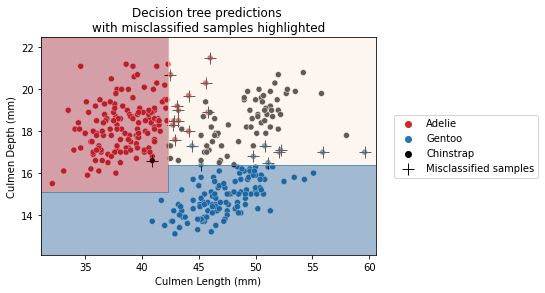

In [ ]:
# plot the original dataset
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# plot the misclassified samples
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0], y=culmen_columns[1],
                     label="Misclassified samples", marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

We observe that several samples have been misclassified by the classifier.

We mentioned that boosting relies on creating a new classifier which tries to
correct these misclassifications. In scikit-learn, learners have a
parameter `sample_weight` which forces it to pay more attention to
samples with higher weights during the training.

This parameter is set when calling
`classifier.fit(X, y, sample_weight=weights)`.
We will use this trick to create a new classifier by 'discarding' all
correctly classified samples and only considering the misclassified samples.
Thus, misclassified samples will be assigned a weight of 1 and well
classified samples will be assigned a weight of 0.

In [ ]:
sample_weight = np.zeros_like(target, dtype=int)
sample_weight[misclassified_samples_idx] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

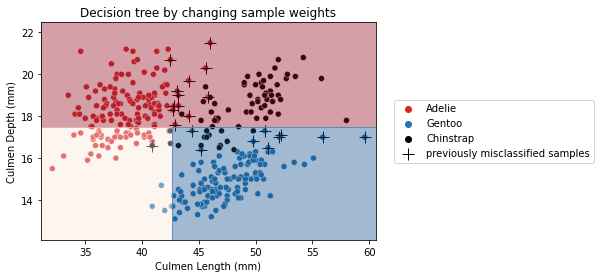

In [ ]:
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0], y=culmen_columns[1],
                     label="previously misclassified samples", marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree by changing sample weights")

In [ ]:
target_predicted = tree.predict(data)
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(f"Number of samples previously misclassified and "
      f"still misclassified: {len(remaining_misclassified_samples_idx)}")

Number of samples previously misclassified and still misclassified: 0


We see that the decision function drastically changed. Qualitatively, we see that the previously misclassified samples are now correctly classified.

However, we are making mistakes on previously well classified samples. Thus, we get the intuition that we should weight the predictions of each classifier differently, most probably by using the number of mistakes each classifier is making.



In [ ]:
ensemble_weight = [
                   (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
                   (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

To summarize, boosting learns several classifiers, each of which will
focus more or less on specific samples of the dataset. Boosting is thus
different from bagging: here we never resample our dataset, we just assign
different weights to the original dataset.

Boosting requires some strategy to combine the learners together:

* one needs to define a way to compute the weights to be assigned
  to samples;
* one needs to assign a weight to each learner when making predictions.

Indeed, we defined a really simple scheme to assign sample weights and
learner weights. However, there are statistical theories (like in AdaBoost)
for how these sample and learner weights can be optimally calculated.


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=3,
                              algorithm="SAMME", random_state=0)
adaboost.fit(data, target)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

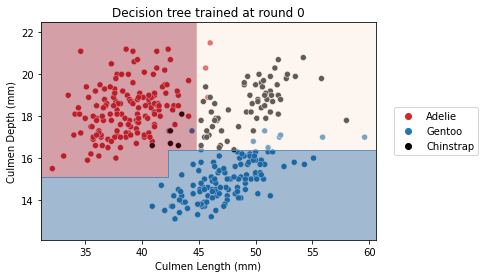

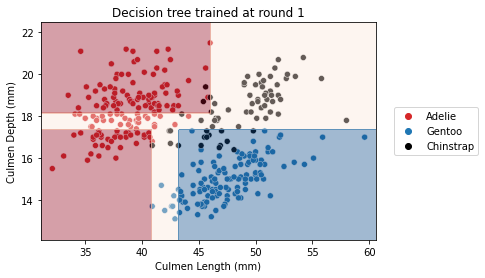

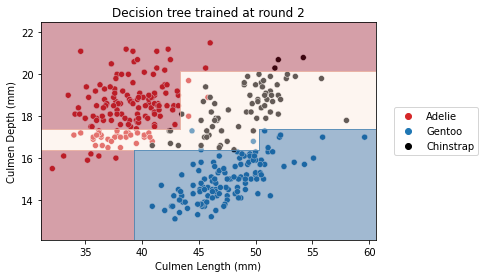

In [ ]:
for boosting_round, tree in enumerate(adaboost.estimators_):
  plt.figure() 
  ax = sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                       hue=target_column, data=penguins,
                       palette=palette)
  plot_decision_function(tree, range_features, ax=ax)
  plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
  _ = plt.title(f"Decision tree trained at round {boosting_round}")

In [ ]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [ ]:
print(f"Error of each classifier: {adaboost.estimator_errors_}")

Error of each classifier: [0.05263158 0.05864198 0.08787269]


# Exercise M6.03

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5
)

Then, create an AbaBoostRegressor. Use the function sklearn.model_selection.validation_curve to get training and test scores by varying the number of estimators. Use the mean absolute error as a metric by passing scoring="neg_mean_absolute_error". Hint: vary the number of estimators between 1 and 60.

In [ ]:
import numpy as np 
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.model_selection import validation_curve 

adaboost = AdaBoostRegressor() 
param_range = np.unique(np.logspace(0, 1.8, num=30).astype(int))
train_scores, test_scores = validation_curve(
    adaboost, data_train, target_train,
    param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_absolute_error", n_jobs=2
)
train_errors, test_errors = -train_scores, -test_scores

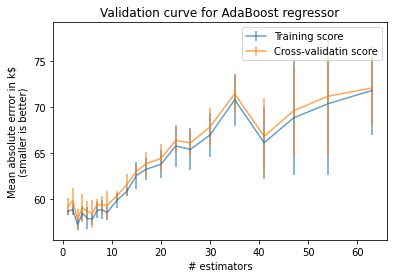

In [ ]:
import matplotlib.pyplot as plt 
plt.errorbar(param_range, train_errors.mean(axis=1), yerr=train_errors.std(axis=1),
             label="Training score", alpha=0.7)
plt.errorbar(param_range, test_errors.mean(axis=1), yerr=test_errors.std(axis=1),
             label="Cross-validatin score", alpha=0.7)
plt.legend()
plt.ylabel("Mean absolute errror in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for AdaBoost regressor")

Plotting the validation curve, we can see that AdaBoost is not immune against overfitting. Indeed, there is an optimal number of estimators to be found. Adding too many estimators is detrimental for the performance of the model.



In [ ]:
from sklearn.ensemble import RandomForestRegressor 

forest = RandomForestRegressor()
train_scores, test_scores = validation_curve(
    forest, data_train, target_train,
    param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_absolute_error", n_jobs=2
)
train_errors, test_errors = -train_scores, -test_scores

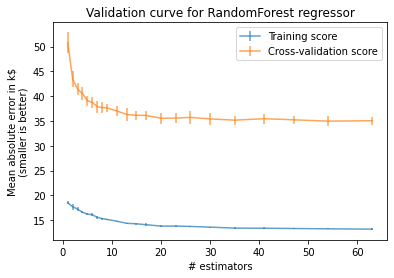

In [ ]:
plt.errorbar(param_range, train_errors.mean(axis=1), yerr=train_errors.std(axis=1),
             label="Training score", alpha=0.7)
plt.errorbar(param_range, test_errors.mean(axis=1), yerr=test_errors.std(axis=1),
             label="Cross-validation score", alpha=0.7)
plt.legend() 
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for RandomForest regressor")

In contrary to the AdaBoost regressor, we can see that increasing the number trees in the forest will increase the statistical performance (by decreasing the mean absolute error) of the random forest. In fact, a random forest has less chance to suffer from overfitting than AdaBoost when increasing the number of estimators.

# Gradient-boosting decision tree (GBDT)

Gradient-boosting differs from AdaBoost due to the following reason: instead of assigning weights to specific samples, GBDT will fit a decision tree on the residuals error (hence the name "gradient") of the previous tree. Therefore, each new tree in the ensemble predicts the error made by the previous learner instead of predicting the target directly.

In [ ]:
import pandas as pd 
import numpy as np 

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)

def generate_data(n_samples=50):
  """Generate synthetic dataset. Returns `data_train`, `data_test`,`target_train`."""
  x_max, x_min = 1.4, -1.4
  len_x = x_max - x_min
  x = rng.rand(n_samples) * len_x - len_x / 2
  noise = rng.randn(n_samples) * 0.3
  y = x ** 3 - 0.5 * x ** 2 + noise

  data_train = pd.DataFrame(x, columns=["Feature"])
  data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300), columns=["Feature"])
  target_train = pd.Series(y, name="Target")
  return data_train, data_test, target_train 


data_train, data_test, target_train = generate_data()

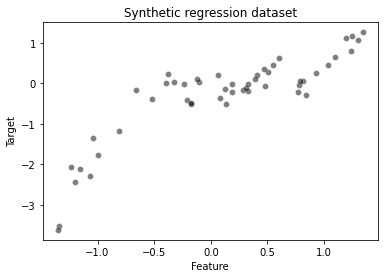

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
_ = plt.title("Synthetic regression dataset")

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

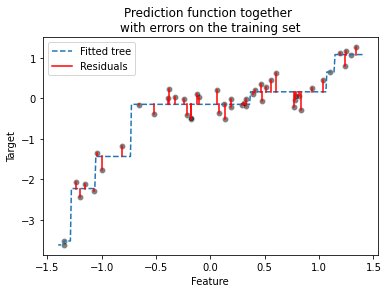

In [ ]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test, target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"], target_train, target_train_predicted):
  lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]], ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")

Indeed, our initial tree was not expressive enough to handle the complexity of the data, as shown by the residuals. In a gradient-boosting algorithm, the idea is to create a second tree which, given the same data data, will try to predict the residuals instead of the vector target. We would therefore have a tree that is able to predict the errors made by the initial tree.

In [ ]:
residuals = target_train - target_train_predicted 

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

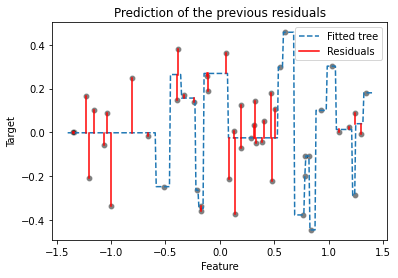

In [ ]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(data_test, target_test_predicted_residuals, "--")

# plot the residuals of the predicted residuals
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction of the previous residuals")

In [ ]:
data_max = data_train.iloc[-1, 0]
target_true = target_train.iloc[-1]
target_true_residual = residuals.iloc[-1]

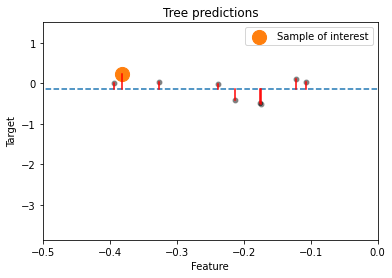

In [ ]:
# Plot the previous information:
#   * the dataset
#   * the predictions
#   * the residuals

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
plt.plot(data_test, target_test_predicted, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-0.5, 0])
plt.legend()
_ = plt.title("Tree predictions")

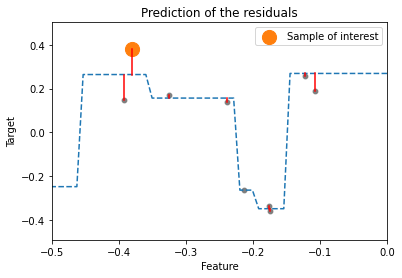

In [ ]:
# Plot the previous information:
#   * the residuals committed by the first tree
#   * the residual predictions
#   * the residuals of the residual predictions

sns.scatterplot(x=data_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(data_test, target_test_predicted_residuals, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true_residual, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-0.5, 0])
plt.legend()
_ = plt.title("Prediction of the residuals")

In [ ]:
print(f"True value to predict for f(x={data_max:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict([[data_max]])[0]
print(f"Prediction of the first decision tree for x={data_max:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.382) = 0.238
Prediction of the first decision tree for x=-0.382: y=-0.145
Error of the tree: 0.383


In [ ]:
print(f"Prediction of the residual for x={data_max:.3f}: "
      f"{tree_residuals.predict([[data_max]])[0]:.3f}")

Prediction of the residual for x=-0.382: 0.264


We see that our second tree is capable of predicting the exact residual (error) of our first tree. Therefore, we can predict the value of x by summing the prediction of the all trees in the ensemble.



In [ ]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict([[data_max]])[0]
)
print(f"Prediction of the first and second decision trees combined for "
      f"x={data_max:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=-0.382: y=0.120
Error of the tree: 0.118


We chose a sample for which only two trees were enough to make the perfect prediction. However, we saw in the previous plot that two trees were not enough to correct the residuals of all samples. Therefore, one needs to add several trees to the ensemble to successfully correct the error. (i.e. the second tree corrects the first tree's error, while the third tree corrects the second tree's error and so on.)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate 

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor 

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error", n_jobs=-1
)

In [ ]:
print("Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.393 +/- 2.913 k$
Average fit time: 8.640 seconds
Average score time: 0.012 seconds


In [ ]:
from sklearn.ensemble import RandomForestRegressor 

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=-1) 
cv_results_rf = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error", n_jobs=-1
)

In [ ]:
print("Random Forest")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{cv_results_rf['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random Forest
Mean absolute error via cross-validation: 46.387 +/- 2.915 k$
Average fit time: 8.666 seconds
Average score time: 0.012 seconds


# Exercise M6.04

verify if a GBDT tends to overfit if the number of estimators is not appropriate as previously seen for AdaBoost;

use the early-stopping strategy to avoid adding unnecessary trees, to get the best statistical performances.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=0,
                                                                    test_size=0.5)

create a gradient boosting decision tree and create a validation curve to assess the impact of the number of trees on the statistical performance of the model. Use the mean absolute error to assess the statistical performance of the model.

In [ ]:
import numpy as np 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import validation_curve 

gbdt = GradientBoostingRegressor()
param_range = np.unique(np.logspace(0, 1.8, num=30).astype(int))
train_scores, test_scores = validation_curve(gbdt, data_train, target_train,
                                             param_name="n_estimators",
                                             param_range=param_range,
                                             scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

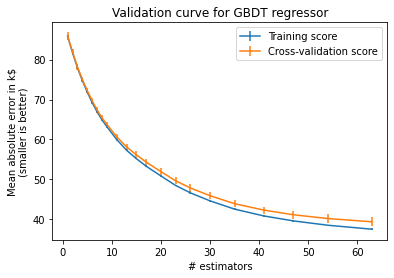

In [ ]:
import matplotlib.pyplot as plt 

plt.errorbar(param_range, train_errors.mean(axis=1), yerr=train_errors.std(axis=1),
             label="Training score")
plt.errorbar(param_range, test_errors.mean(axis=1), yerr=test_errors.std(axis=1),
             label="Cross-validation score")
plt.legend()
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for GBDT regressor")

Unlike AdaBoost, the gradient boosting model will always improve when increasing the number of trees in the ensemble. However, it will reach a plateau where adding new trees will just make fitting and scoring slower.

To avoid adding new unnecessary tree, gradient boosting offers an early-stopping option. Internally, the algorithm will use an out-of-sample set to compute the statistical performance of the model at each addition of a tree. Thus, if the statistical performance are not improving for several iterations, it will stop adding trees.

In [ ]:
gbdt = GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)
gbdt.fit(data_train, target_train)
gbdt.n_estimators_

118

# Speeding-up gradient-boosting

we present a modified version of gradient boosting which uses a reduced number of splits when building the different trees. This algorithm is called "histogram gradient boosting" in scikit-learn.

We previously mentioned that random-forest is an efficient algorithm since each tree of the ensemble can be fitted at the same time independently. Therefore, the algorithm scales efficiently with both the number of cores and the number of samples.

In gradient-boosting, the algorithm is a sequential algorithm. It requires the N-1 trees to have been fit to be able to fit the tree at stage N. Therefore, the algorithm is quite computationally expensive. The most expensive part in this algorithm is the search for the best split in the tree which is a brute-force approach: all possible split are evaluated and the best one is picked. We explained this process in the notebook "tree in depth", which you can refer to.

To accelerate the gradient-boosting algorithm, one could reduce the number of splits to be evaluated. As a consequence, the statistical performance of such a tree would be reduced. However, since we are combining several trees in a gradient-boosting, we can add more estimators to overcome this issue.

In [ ]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [ ]:
from sklearn.model_selection import cross_validate 
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error", n_jobs=-1
)

In [ ]:
print("Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.414 +/- 2.914 k$
Average fit time: 8.652 seconds
Average score time: 0.012 seconds


We recall that a way of accelerating the gradient boosting is to reduce the number of split considered within the tree building. One way is to bin the data before to give them into the gradient boosting. A transformer called KBinsDiscretizer is doing such transformation. Thus, we can pipeline this preprocessing with the gradient boosting.

We can first demonstrate the transformation done by the KBinsDiscretizer.

In [ ]:
import numpy as np 
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=256, encode="ordinal", strategy="quantile")
data_trans = discretizer.fit_transform(data)
data_trans

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

array([[249.,  39., 231., ...,  83., 162.,  30.],
       [248.,  19., 203., ...,  28., 161.,  30.],
       [242.,  49., 249., ..., 125., 160.,  29.],
       ...,
       [ 17.,  15., 126., ...,  49., 200.,  82.],
       [ 23.,  16., 136., ...,  29., 200.,  77.],
       [ 53.,  14., 130., ...,  93., 199.,  81.]])

We see that the discretizer transforms the original data into an integer. This integer represents the bin index when the distribution by quantile is performed. We can check the number of bins per feature.

In [ ]:
[len(np.unique(col)) for col in data_trans.T]

[256, 50, 256, 253, 256, 256, 207, 235]

After this transformation, we see that we have at most 256 unique values per features. Now, we will use this transformer to discretize data before training the gradient boosting regres

In [ ]:
from sklearn.pipeline import make_pipeline

gradient_boosting = make_pipeline(
    discretizer, GradientBoostingRegressor(n_estimators=200)
)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error", n_jobs=-1
)

In [ ]:
print("Gradient Boosting Decision Tree with KBinsDiscretizer")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree with KBinsDiscretizer
Mean absolute error via cross-validation: 45.809 +/- 2.195 k$
Average fit time: 5.320 seconds
Average score time: 0.017 seconds


Here, we see that the fit time has been drastically reduced but that the statistical performance of the model is identical. Scikit-learn provides a specific classes which are even more optimized for large dataset, called HistGradientBoostingClassifier and HistGradientBoostingRegressor. Each feature in the dataset data is first binned by computing histograms, which are later used to evaluate the potential splits. The number of splits to evaluate is then much smaller. This algorithm becomes much more efficient than gradient boosting when the dataset has over 10,000 samples.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor 

histogram_gradient_boosting = HistGradientBoostingRegressor(max_iter=200, random_state=0)
cv_results_hgbdt = cross_validate(
    histogram_gradient_boosting, data, target, scoring="neg_mean_absolute_error", n_jobs=-1
)

In [ ]:
print("Histogram Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_hgbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_hgbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_hgbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_hgbdt['score_time'].mean():.3f} seconds")

Histogram Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 43.758 +/- 2.694 k$
Average fit time: 1.081 seconds
Average score time: 0.075 seconds


# Hyperparameter tuning

## Random forest

The main parameter to tune for random forest is the `n_estimators` parameter.
In general, the more trees in the forest, the better the statistical
performance will be. However, it will slow down the fitting and prediction
time. The goal is to balance computing time and statistical performance when
setting the number of estimators when putting such learner in production.

The `max_depth` parameter could also be tuned. Sometimes, there is no need
to have fully grown trees. However, be aware that with random forest, trees
are generally deep since we are seeking to overfit the learners on the
bootstrap samples because this will be mitigated by combining them.
Assembling underfitted trees (i.e. shallow trees) might also lead to an
underfitted forest.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

In [ ]:
import pandas as pd 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [10, 20, 30],
    "max_depth": [3, 5, None],
}
grid_search = GridSearchCV(
    RandomForestRegressor(n_jobs=-1), param_grid=param_grid,
    scoring="neg_mean_absolute_error", n_jobs=-1
)
grid_search.fit(data_train, target_train)

columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "rank_test_score"]
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results[columns].sort_values(by="rank_test_score")

,param_n_estimators,param_max_depth,mean_test_score,rank_test_score
8,30,None,34.606427,1
7,20,None,34.918017,2
6,10,None,36.295933,3
5,30,5,48.714815,4
4,20,5,48.816838,5
3,10,5,48.875148,6
1,20,3,56.986248,7
2,30,3,57.139978,8
0,10,3,57.271444,9


## Gradient-boosting decision trees

For gradient-boosting, parameters are coupled, so we cannot set the
parameters one after the other anymore. The important parameters are
`n_estimators`, `max_depth`, and `learning_rate`.

Let's first discuss the `max_depth` parameter.
We saw in the section on gradient-boosting that the algorithm fits the error
of the previous tree in the ensemble. Thus, fitting fully grown trees will
be detrimental.
Indeed, the first tree of the ensemble would perfectly fit (overfit) the data
and thus no subsequent tree would be required, since there would be no
residuals.
Therefore, the tree used in gradient-boosting should have a low depth,
typically between 3 to 8 levels. Having very weak learners at each step will
help reducing overfitting.

With this consideration in mind, the deeper the trees, the faster the
residuals will be corrected and less learners are required. Therefore,
`n_estimators` should be increased if `max_depth` is lower.

Finally, we have overlooked the impact of the `learning_rate` parameter
until now. When fitting the residuals, we would like the tree
to try to correct all possible errors or only a fraction of them.
The learning-rate allows you to control this behaviour.
A small learning-rate value would only correct the residuals of very few
samples. If a large learning-rate is set (e.g., 1), we would fit the
residuals of all samples. So, with a very low learning-rate, we will need
more estimators to correct the overall error. However, a too large
learning-rate tends to obtain an overfitted ensemble,
similar to having a too large tree depth.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    "n_estimators": [10, 30, 50],
    "max_depth": [3, 5, None],
    "learning_rate": [0.1, 1],
}
grid_search = GridSearchCV(
    GradientBoostingRegressor(), param_grid=param_grid,
    scoring="neg_mean_absolute_error", n_jobs=-1
)
grid_search.fit(data_train, target_train)

columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "rank_test_score"]
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results[columns].sort_values(by="rank_test_score")

,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score,rank_test_score
5,50,5,0.1,35.655336,1
11,50,3,1,36.707355,2
10,30,3,1,37.500077,3
13,30,5,1,38.988425,4
4,30,5,0.1,39.267988,5
12,10,5,1,39.423073,6
14,50,5,1,39.809200,7
2,50,3,0.1,40.600799,8
9,10,3,1,41.602175,9
7,30,None,0.1,45.567984,10


# Exercise M6.05

In [ ]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

First, create a histogram gradient boosting regressor. You can set the trees number to be large, and configure the model to use early-stopping.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hist_gbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=0
)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": [3, 8],
    "max_leaf_nodes": [15, 31],
    "learning_rate": [0.1, 1],
}
search = GridSearchCV(hist_gbdt, params)

Finally, we will run our experiment through cross-validation. In this regard, define a 5-fold cross-validation. Besides, be sure to shuffle the data. Subsequently, use the function sklearn.model_selection.cross_validate to run the cross-validation. You should also set return_estimator=True, so that we can investigate the inner model trained via cross-validation.

In [ ]:
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import KFold 

cv = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_validate(
    search, data, target, cv=cv, return_estimator=True, n_jobs=2
)
results

{'estimator': [GridSearchCV(estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                       max_iter=1000,
                                                       random_state=0),
               param_grid={'learning_rate': [0.1, 1], 'max_depth': [3, 8],
                           'max_leaf_nodes': [15, 31]}),
  GridSearchCV(estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                       max_iter=1000,
                                                       random_state=0),
               param_grid={'learning_rate': [0.1, 1], 'max_depth': [3, 8],
                           'max_leaf_nodes': [15, 31]}),
  GridSearchCV(estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                       max_iter=1000,
                                                       random_state=0),
               param_grid={'learning_rate': [0.1, 1], 'max_depth': [3

In [ ]:
print(f"R2 score with cross-validation:\n"
      f"{results['test_score'].mean():.3f} +/- "
      f"{results['test_score'].std():.3f}")

R2 score with cross-validation:
0.839 +/- 0.006


In [ ]:
for estimator in results["estimator"]:
  print(estimator.best_params_)
  print(f"# trees: {estimator.best_estimator_.n_iter_}")

{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 528
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 447
{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 576
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 290
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 414


We observe that the parameters are varying. We can get the intuition that results of the inner CV are very close for certain set of parameters.

Inspect the results of the inner CV for each estimator of the outer CV. Aggregate the mean test score for each parameter combination and make a box plot of these scores.

In [ ]:
import pandas as pd 
index_columns = [f"param_{name}" for name in params.keys()]
columns = index_columns + ["mean_test_score"]

inner_cv_results = []
for cv_idx, estimator in enumerate(results["estimator"]):
  search_cv_results = pd.DataFrame(estimator.cv_results_)
  search_cv_results = search_cv_results[columns].set_index(index_columns)
  search_cv_results = search_cv_results.rename(
      columns={"mean_test_score":f"CV {cv_idx}"}
  )
  inner_cv_results.append(search_cv_results)

inner_cv_results = pd.concat(inner_cv_results, axis=1).T

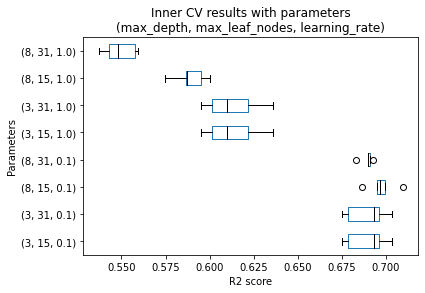

In [ ]:
import matplotlib.pyplot as plt 
color= {"whiskers":"black", "medians":"black", "caps":"black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title("Inner CV results with parameters\n"
              "(max_depth, max_leaf_nodes, learning_rate)")

We see that the first 4 ranked set of parameters are very close. We could select any of these 4 combinations. It coincides with the results we observe when inspecting the best parameters of the outer CV.

# Wrap-up quiz 6

In [ ]:
import pandas as pd 
blood_transfusion = pd.read_csv("./datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

n this dataset, the column "Class" is the target vector containing the labels that our model should predict.

For all the questions below, make a cross-validation evaluation using a 10-fold cross-validation strategy.

Evaluate the performance of a sklearn.dummy.DummyClassifier that always predict the most frequent class seen during the training. Be aware that you can pass a list of score to compute in sklearn.model_selection.cross_validate by setting the parameter scoring.

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy_model = DummyClassifier(strategy="most_frequent", random_state=0)
cv_results = cross_validate(
    dummy_model, data, target, cv=10, scoring=["accuracy", "balanced_accuracy"]
)
cv_results["test_accuracy"].mean()

0.762054054054054

In [ ]:
print(f"Average accuracy: {cv_results['test_accuracy'].mean():.3f}")
print(f"Average balanced accuracy: "
      f"{cv_results['test_balanced_accuracy'].mean():.3f}")

Average accuracy: 0.762
Average balanced accuracy: 0.500


In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=0)
cv_results = cross_validate(
    tree_model, data, target, cv=10, scoring=["accuracy", "balanced_accuracy"]
)
cv_results["test_balanced_accuracy"].mean()

0.5159872721018232

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
scores_tree = cross_val_score(
    tree, data, target, cv=10, scoring="balanced_accuracy", n_jobs=2
)
scores_tree.mean()

0.5159872721018232

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

rf_model = RandomForestClassifier(n_estimators=300, n_jobs=2)
scores_rf = cross_val_score(
    rf_model, data, target, cv=10, scoring="balanced_accuracy", n_jobs=2
)
scores_rf.mean()

0.5280873753009976

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier 

gb_model = GradientBoostingClassifier(n_estimators=300)
scores_gb = cross_val_score(
    gb_model, data, target, cv=10, scoring="balanced_accuracy", n_jobs=2
)
scores_gb.mean()

0.5364207086343309

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import KFold 

n_try = 10 
scores_rf, scores_gbdt = [], []

for seed in range(n_try):
  cv = KFold(n_splits=10, shuffle=True, random_state=seed)
  rf = RandomForestClassifier(n_estimators=300, n_jobs=2)
  scores = cross_val_score(
      rf, data, target, cv=cv, scoring="balanced_accuracy", n_jobs=2
  )
  scores_rf.append(scores.mean())

  gbdt = GradientBoostingClassifier(n_estimators=300)
  scores = cross_val_score(
      gbdt, data, target, cv=cv, scoring="balanced_accuracy", n_jobs=2
  )
  scores = cross_val_score(
      gbdt, data, target, cv=cv, scoring="balanced_accuracy", n_jobs=2
  )
  scores_gbdt.append(scores.mean())

compare = [s_gbdt > s_rf for s_gbdt, s_rf in zip(scores_gbdt, scores_rf)]
sum(compare)

9

## question 7

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gbdt = HistGradientBoostingClassifier(
    max_iter=1000, early_stopping=True, random_state=0
)

scores_hist = cross_val_score(
    hist_gbdt, data, target, cv=10, scoring="balanced_accuracy", n_jobs=2
)
scores_hist.mean()

0.578672170622635

In [ ]:
cv_results = cross_validate(
    hist_gbdt, data, target, cv=10, scoring="balanced_accuracy", n_jobs=2,
    return_estimator=True,
)
cv_results["test_score"].mean()

0.578672170622635

In [ ]:
for estimator in cv_results["estimator"]:
  print(f"# trees: {estimator.n_iter_}")

# trees: 32
# trees: 31
# trees: 32
# trees: 25
# trees: 31
# trees: 31
# trees: 45
# trees: 22
# trees: 48
# trees: 36


In [ ]:
import numpy as np
np.mean([estimator.n_iter_ for estimator in cv_results["estimator"]])

33.3

## Question 8

The documentation states that BalancedBaggingClassifier, each bootstrap sample will be resampled to achieve a desired class balance.

In [ ]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 12.9MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(
    base_estimator=hist_gbdt, n_estimators=50, n_jobs=2, random_state=0)

scores_bbc = cross_val_score(
    bbc, data, target, cv=10, scoring="balanced_accuracy", n_jobs=2
)
scores_bbc.mean()

0.6010663914688682